In [1]:
from pystock.stock_scanner import Stock, StockScanner
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer, accuracy_score, roc_auc_score, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, Reshape, TimeDistributed, LayerNormalization, Attention
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
tf.random.set_seed(11)
np.random.seed(11)

# Get stock data

In [2]:
s = Stock('GME')
s.get_technical_data(start_date=datetime(2018,1,1))
TIME = s.technical.index
T = s.technical[['open','high','low','volume','close',]].copy()
T.shape

(804, 5)

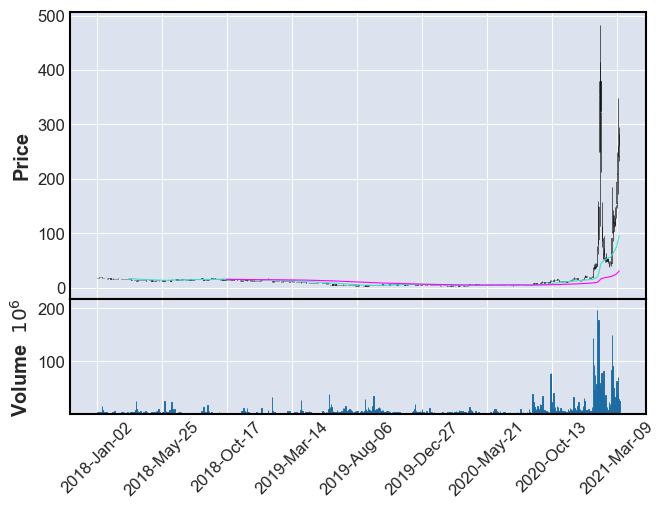

In [3]:
s.plot_chart()

# Preprocess


## Min-max Scaling and Train/Test Split
Below, we apply a min-max scaler to the dataset, and then convert it to a supervised learning problem. Basically, we have "sliding window", that divides the dataset into many different windows of length 20 days, that allow us to predict the 21st day. As the window slides from left to right, we are able to use a LSTM model to predict a "future" day from 20 preceding days.

### Create features for predicting next day close:

In [40]:
scaler_ohlv = StandardScaler() #MinMaxScaler(feature_range=(0,1))
scaler_close = StandardScaler()
T = T.values
T[:,0:4] = scaler_ohlv.fit_transform(T[:,0:4])
T[:,4:] = scaler_close.fit_transform(T[:,4:])

In [41]:
train_size = int(len(T) * 0.8)
test_size = int(len(T) - train_size)
train, test = T[0:train_size, :], T[train_size:, :]
assert T.shape[0] == train.shape[0] + test.shape[0], "Train and test samples must add up to dataset length. Check for leaking of train into test."
train.shape, test.shape

((643, 5), (161, 5))

In [42]:
# Method for create features from the time series data
def create_features(data, window_size):
    """ Create timeseries dataset based on window_size with label being next days close price. """
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        X.append(window)
        Y.append(data[i + window_size, 4])
    return np.array(X), np.array(Y)


# Roughly one month of trading assuming 5 trading days per week
window_size = 20
n_features = train.shape[1]
X_train, y_train = create_features(train, window_size)

X_test, y_test = create_features(test, window_size)

# Reshape to the format of [batch, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], window_size, n_features))

X_test = np.reshape(X_test, (X_test.shape[0], window_size, n_features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 20, 5), (141, 20, 5), (623,), (141,))

### Create feature for predicting next day up/down:

<AxesSubplot:>

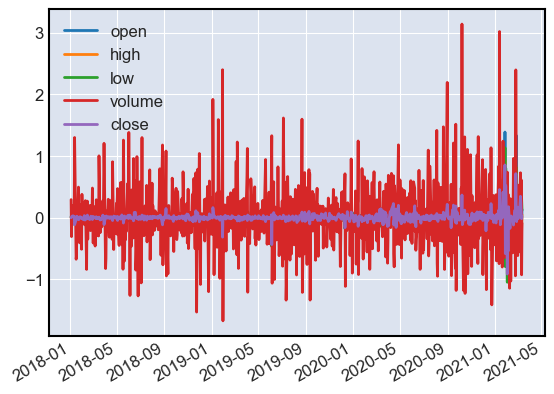

In [4]:
# Data for 
T_binary = np.log(T).diff().copy()
T_binary.plot()

In [5]:
scaler_ohlv = StandardScaler() #MinMaxScaler(feature_range=(0,1))
scaler_close = StandardScaler()
T_binary = T_binary.values[1:] # from 1 becuase first timestep is nan
T_binary[:,0:4] = scaler_ohlv.fit_transform(T_binary[:,0:4])
T_binary[:,4:] = scaler_close.fit_transform(T_binary[:,4:])

In [6]:
train_size = int(len(T_binary) * 0.8)
test_size = int(len(T_binary) - train_size)
train, test = T_binary[0:train_size, :], T_binary[train_size:, :]
assert T_binary.shape[0] == train.shape[0] + test.shape[0], "Train and test samples must add up to dataset length. Check for leaking of train into test."
train.shape, test.shape

((642, 5), (161, 5))

In [7]:
def create_features_binary_from_close_price(data, window_size):
    """ Create timeseries dataset based on window_size of ohlc data with label being up (1) or down (0) the next day."""
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        if window[-1,4] > data[i+window_size, 4]:
            y = 0 # down next day
        else: 
            y = 1 # up next day
        X.append(window)
        Y.append(y)
    return np.array(X), np.array(Y)

def create_features_binary(data, window_size):
    """ Create timeseries dataset based on window_size of differenced ohlc data with label being up (1) or down (0) the next day."""
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        if data[i+window_size, 4] < 0:
            y = 0 # down next day
        else: 
            y = 1 # up next day
        X.append(window)
        Y.append(y)
    return np.array(X), np.array(Y)

# Roughly one month of trading assuming 5 trading days per week
window_size = 20
n_features = train.shape[1]
X_train, y_train = create_features_binary(train, window_size)

X_test, y_test = create_features_binary(test, window_size)

# Reshape to the format of [batch, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], window_size, n_features))

X_test = np.reshape(X_test, (X_test.shape[0], window_size, n_features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((622, 20, 5), (141, 20, 5), (622,), (141,))

# Building and training the LSTM RNN Model
Below, we build a LSTM model that consists of one LSTM layer with a density of 50 neurons and a RELU activation function, as well as a Dropout regularization layer. We add a model checkpoint that is looking to minimize the validation set's loss. We save each model that consists of a lower validation loss compared to any model that came before it.

In [9]:
def modelBinary():
    """Model to predict whether next day is up or down. """
    # Building model
    model = Sequential()

    # model.add(Bidirectional(LSTM(units = 50, activation = 'relu', return_sequences = False), 
    #                         input_shape = (None, X_train.shape[2])
    #                        )
    #          )
    model.add(LSTM(units = 100, activation = 'relu', return_sequences = False, input_shape = (None, X_train.shape[2])))
    model.add(LayerNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid')) # use activation='linear' for predicting price instead of binary label
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam') # use loss = 'mean_squared_error' for predicting price instead of binary label
    return model

In [43]:
def modelClose():
    """Model to predict next day close price. """
    # Building model
    model = Sequential()

    # model.add(Bidirectional(LSTM(units = 50, activation = 'relu', return_sequences = False), 
    #                         input_shape = (None, X_train.shape[2])
    #                        )
    #          )
    model.add(LSTM(units = 100, activation = 'relu', return_sequences = False, input_shape = (None, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'linear')) 
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

In [10]:
model = modelBinary()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               22400     
_________________________________________________________________
layer_normalization (LayerNo (None, 100)               200       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 22,701
Trainable params: 22,701
Non-trainable params: 0
_________________________________________________________________


In [11]:
filepath = 'nn_snapshots/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, y_train, 
                    epochs = 100, 
                    batch_size = 20, 
                    validation_data = (X_test, y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, 
                    shuffle = False)

Epoch 1/100
32/32 [==============================] - 2s 25ms/step - loss: 0.7700 - val_loss: 0.7343

Epoch 00001: val_loss improved from inf to 0.73428, saving model to nn_snapshots\model_epoch_01.hdf5
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7085 - val_loss: 0.7481

Epoch 00002: val_loss did not improve from 0.73428
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7067 - val_loss: 0.7510

Epoch 00003: val_loss did not improve from 0.73428
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6912 - val_loss: 0.7671

Epoch 00004: val_loss did not improve from 0.73428
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6976 - val_loss: 0.7673

Epoch 00005: val_loss did not improve from 0.73428
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 0.6978 - val_loss: 0.8069

Epoch 00006: val_loss did not improve from 0.73428
Epoch 7/100
32/32 [========================

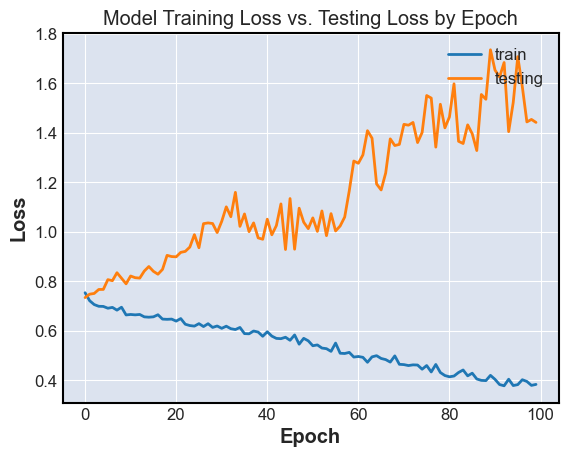

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training Loss vs. Testing Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

In [13]:
np.argmin(history.history['val_loss'])+1

1

# Evaluate closing price model

In [48]:
best_model = load_model('nn_snapshots/model_epoch_20.hdf5')

# Predicting and inverse transforming the predictions

y_pred_train = best_model.predict(X_train)

y_pred_train = scaler_close.inverse_transform(y_pred_train).reshape(-1,)

y_pred_test = best_model.predict(X_test)

y_pred_test = scaler_close.inverse_transform(y_pred_test).reshape(-1,)

# Inverse transforming the actual values, to return them to their original values
y_test = scaler_close.inverse_transform([y_test]).reshape(-1,)
y_train = scaler_close.inverse_transform([y_train]).reshape(-1,)

In [49]:
train_RMSE = np.sqrt(mean_squared_error(y_train, y_pred_train))

test_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
0.5917287796403096 

Test RMSE is: 
34.38965920613013


In [50]:
result_df = pd.DataFrame()

result_df['close_true'] = np.concatenate([y_train, y_test])
result_df['close_pred'] = np.concatenate([y_pred_train, y_pred_test])
result_df['close_true_up'] = result_df['close_true'].diff()>0
result_df['close_pred_up'] = result_df['close_pred'].diff()>0

result_df.tail()

,close_true,close_pred,close_true_up,close_pred_up
759,194.500000,126.775467,True,True
760,246.899994,157.250275,True,True
761,265.000000,214.518448,True,True
762,260.000000,228.000229,False,True
763,264.500000,232.387283,True,True


In [56]:
accuracy_score(result_df['close_true_up'], result_df['close_pred_up'])

0.4973821989528796

<AxesSubplot:>

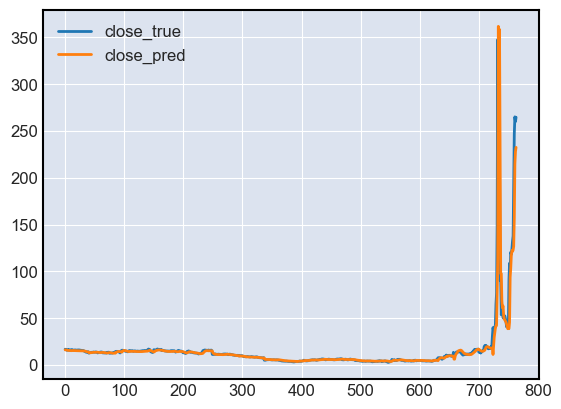

In [52]:
result_df.plot()

# Evaluate binary model (up/down)

In [91]:
best_model = load_model('nn_snapshots/model_epoch_01.hdf5')
y_pred_train = (best_model.predict(X_train)>0.5).astype(int)
y_pred_test = (best_model.predict(X_test)>0.5).astype(int)
print('Train accuracy:', accuracy_score(y_train, y_pred_train), 'Test accuracy: ', accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Train accuracy: 0.5643086816720257 Test accuracy:  0.5531914893617021
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        63
           1       0.58      0.67      0.62        78

    accuracy                           0.55       141
   macro avg       0.54      0.54      0.54       141
weighted avg       0.55      0.55      0.55       141



In [104]:
# Only bought on days where y_pred = 1, then sell the next day.
y_test[(y_pred_test == 1).flatten()].sum()/sum(y_test==1)

0.6666666666666666

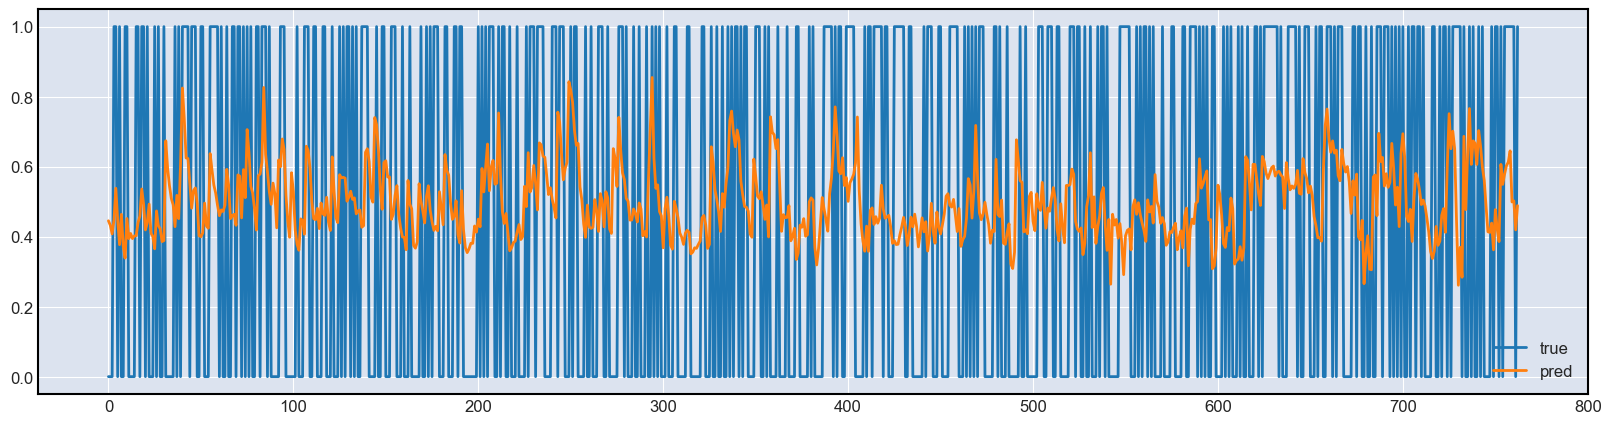

In [83]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
plt.plot(np.concatenate([y_train,y_test]), label='true')
plt.plot(np.concatenate([best_model.predict(X_train),best_model.predict(X_test)]),label='pred')
plt.legend()

# Predict close tomorrow

In [53]:
X_today = T[-20:,:]
y_tmr = best_model.predict(X_today.reshape(-1,X_today.shape[0], n_features))
y_tmr = scaler_close.inverse_transform(y_tmr)
y_tmr

array([[236.89908]], dtype=float32)